In [67]:
import pandas
import matplotlib.pyplot as plt
import pickle
import wntr
from testWN import testWN as twm
import numpy as np
import pandas as pd

from sklearn.cluster import AgglomerativeClustering, FeatureAgglomeration, SpectralClustering
from sklearn.decomposition import PCA

In [2]:
%matplotlib notebook

# Get Network Information

In [3]:
inp_file = '../Networks/BWCNdata/c-town_true_network.inp'
ctown = twm(inp_file)
node_names_all = ctown.wn.node_name_list
node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

n_junctions = len(node_names[2])
n_nodes = len(node_names_all)

pump_df = pd.DataFrame(np.ones(len(link_names[0])).reshape(1,-1), columns=link_names[0])
valves_df = pd.DataFrame(np.ones(len(link_names[2])).reshape(1,-1), columns=link_names[2])

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Networks/BWCNdata/c-town_true_network.inp"; added with type None, units conversion left to user



# Get Connectivity Matrix

Infos about connectivity matrix [here](https://transportgeography.org/?page_id=6969).

In [123]:
A = np.zeros((n_junctions,n_junctions))
links = ctown.wn.links.todict()
for key in links.keys():
    i = np.where([np.array(node_names[2]) == links[key]['start_node_name']])[1]
    j = np.where([np.array(node_names[2]) == links[key]['end_node_name']])[1]
    
    A[i,j] = 1
    A[j,i] = 1

<IPython.core.display.Javascript object>


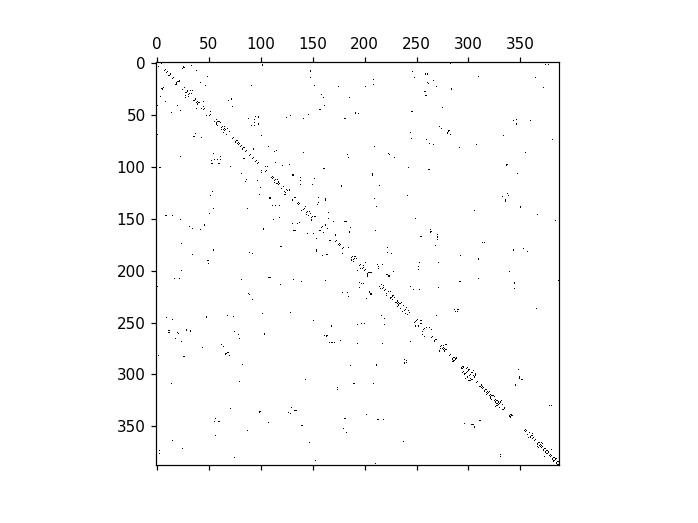

In [124]:
plt.figure()
plt.spy(A)

# Get Coordinates of nodes:

In [196]:
nodes = ctown.wn.nodes.todict()

In [197]:
coords_arr = np.array([nodes[key]['coordinates'] for key in nodes.keys()])
coords = pd.DataFrame(coords_arr, index=node_names_all)

# Clustering

## Prepocess Data:

In [368]:
with open('results.pkl', 'rb') as f:
    results=pickle.load(f)

In [369]:
press_junctions =results.node['pressure'][node_names[2]]
dqual_junctions = results.node['quality'][node_names[2]].diff(axis=0).dropna()
junction_coords = coords.loc[node_names[2]]

Normalize Data:

In [472]:
scaling_press = press_junctions.mean()
scaling_qual = dqual_junctions.mean()
press_junctions /= scaling_press
dqual_junctions /=  scaling_qual

Cluster Settings:

In [473]:
n_clusters = 30

## Pressure Clustering

In [474]:
clustering = FeatureAgglomeration(n_clusters=n_clusters, connectivity=A, linkage='ward').fit(press_junctions.to_numpy())
cluster_labels = pd.DataFrame(clustering.labels_.reshape(1,-1), columns=node_names[2], index=['pressure'])

In [475]:
cluster_labels

,J511,J411,J414,J415,J416,J417,J418,J419,J310,J311,...,J299,J300,J301,J302,J304,J306,J307,J309,J317,J323
pressure,10,7,3,2,1,3,16,16,21,21,...,16,16,14,14,11,11,14,14,4,4


<IPython.core.display.Javascript object>


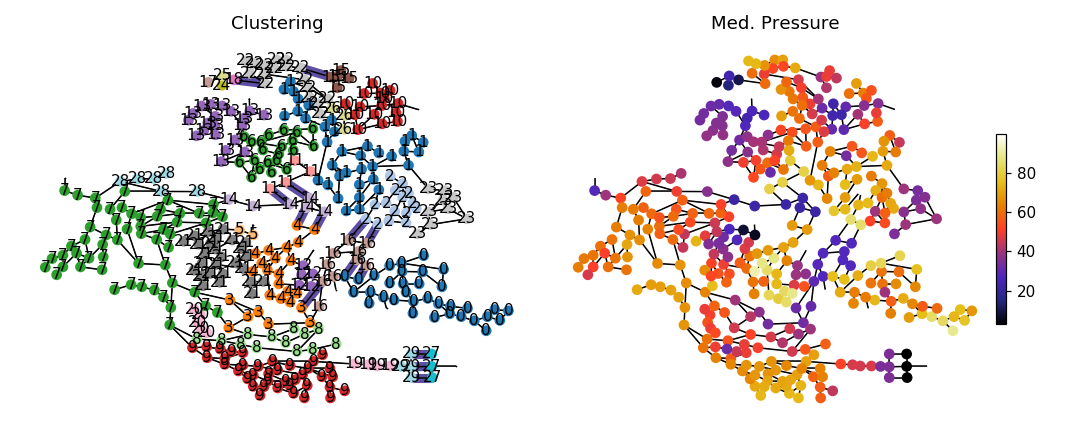

In [476]:
fig_1, ax_1 = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
press = results.node['pressure']
press_med = press.median()

# Highlight pumps
wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, 
                           add_colorbar=False, title='Pumps', ax=ax_1[0])
# Highlight valves
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, 
                           add_colorbar=False, title='Valves', ax=ax_1[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=cluster_labels.loc['pressure'],
                                   node_size=50, node_labels=False, node_cmap='tab20',
                                   add_colorbar=False, title='Clustering', ax=ax_1[0]) 

wntr.graphics.plot_network(ctown.wn, node_attribute=press_med[node_names[2]],node_size=50, 
                           node_cmap='CMRmap', title='Med. Pressure', ax=ax_1[1])  


if False:
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][clustering.labels_==i].mean()
        ax_1[0].text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8), alpha=0.8))
if True:
    for i in range(n_junctions):
        node_loc = coords.loc[node_names[2][i]]
        ax_1[0].text(*node_loc.tolist(), str(clustering.labels_[i]), ha="center", va="center")
    


fig_1.tight_layout()



### Evaluation

In [495]:
# Calculate cluster mean and standard deviation
jun_cl_press_group = press_junctions.groupby(cluster_labels.loc['pressure'], axis=1)
jun_cl_press_mean = jun_cl_press_group.mean()
jun_cl_press_std = jun_cl_press_group.std()

<IPython.core.display.Javascript object>


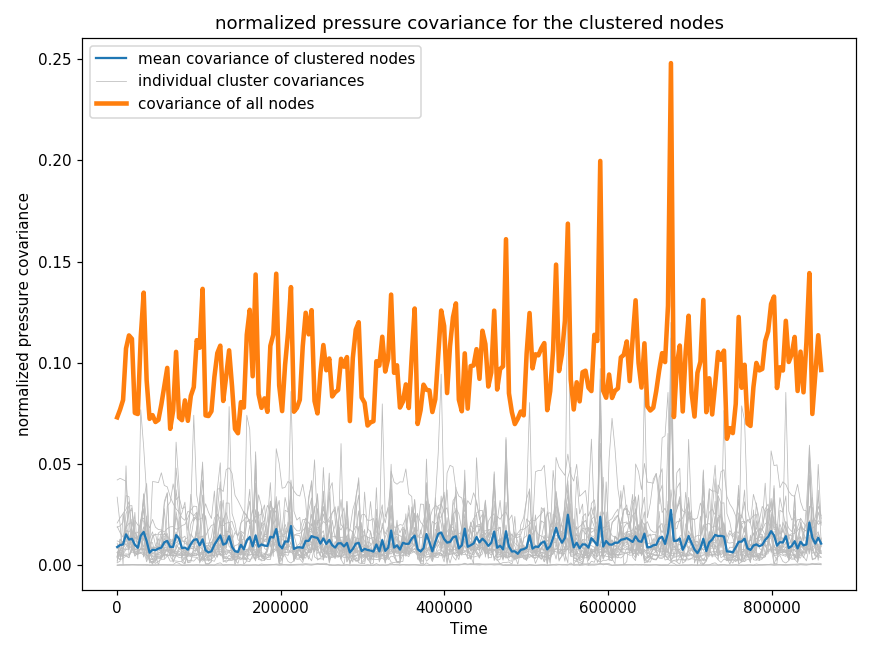

In [518]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

ax_2.plot(jun_cl_press_std, color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_press_std.mean(axis=1), label='mean covariance of clustered nodes')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.5, label='individual cluster covariances')


press_std_ges = press_junctions.std(axis=1)
ax_2.plot(press_std_ges, linewidth=3, label='covariance of all nodes')
ax_2.set_xlabel('Time')
ax_2.set_ylabel('normalized pressure covariance')
ax_2.set_title('normalized pressure covariance for the clustered nodes')

ax_2.legend()
fig_2.tight_layout()   

<IPython.core.display.Javascript object>


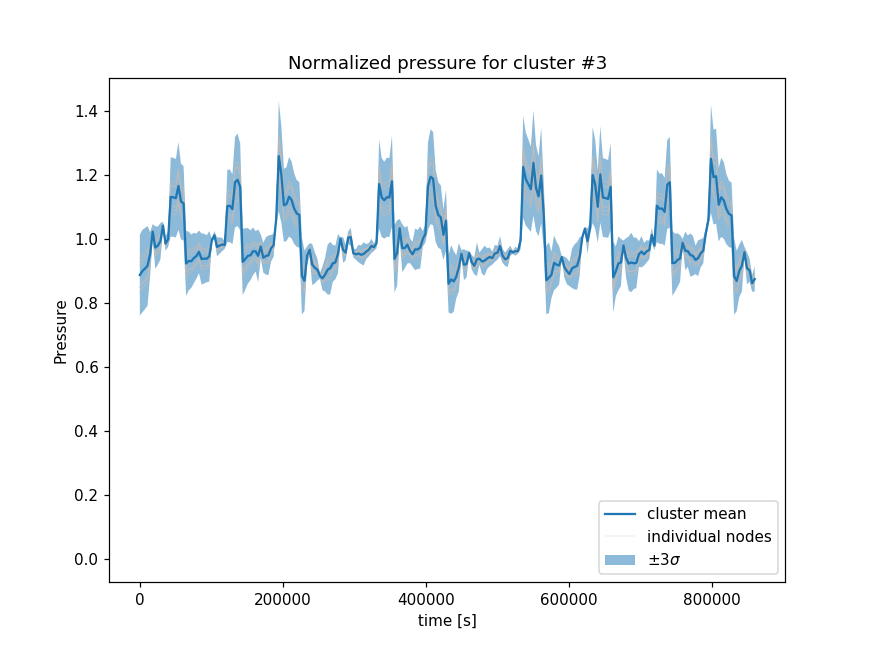

Text(0, 0.5, 'Pressure')

In [524]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

cluster_i=3


ax_2.fill_between(jun_cl_press_mean.index,
                  (jun_cl_press_mean[[cluster_i]]-3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(),
                  (jun_cl_press_mean[[cluster_i]]+3*jun_cl_press_std[[cluster_i]]).to_numpy().flatten(), 
                  alpha=0.5, label='$\pm 3\sigma$')
ax_2.plot(jun_cl_press_group.get_group(cluster_i), color='#bbbbbb', linewidth=0.5)
ax_2.plot(jun_cl_press_mean[[cluster_i]], label='cluster mean')
ax_2.plot([0,0],[0,0], color='#bbbbbb', linewidth=0.2, label='individual nodes')

ax_2.legend()
ax_2.set_title('Normalized pressure for cluster #{}'.format(cluster_i))
ax_2.set_xlabel('time [s]')
ax_2.set_ylabel('Pressure')


## Quality Clustering

In [362]:
clustering = FeatureAgglomeration(n_clusters=n_clusters, connectivity=A, linkage='ward').fit(dqual_junctions.to_numpy())
cluster_labels = cluster_labels.append(pd.DataFrame(clustering.labels_.reshape(1,-1), 
                                   columns=node_names[2], 
                                   index=['quality']))


<IPython.core.display.Javascript object>


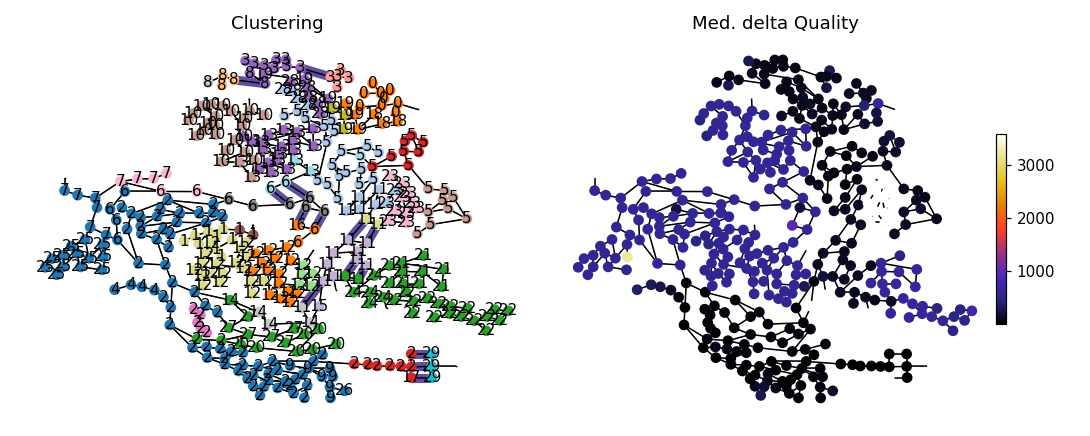

In [356]:
fig_2, ax_2 = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True)
dqual = results.node['quality'].diff().dropna()
dqual_med = dqual.mean()

wntr.graphics.plot_network(ctown.wn, link_attribute=pump_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Pumps', ax=ax_2[0])
wntr.graphics.plot_network(ctown.wn, link_attribute=valves_df.loc[0],node_size=1, link_width=6, add_colorbar=False, title='Valves', ax=ax_2[0])

lines = wntr.graphics.plot_network(ctown.wn, node_attribute=cluster_labels.loc['pressure'],
                                   node_size=50, node_labels=False, node_cmap='tab20',
                                   add_colorbar=False, title='Clustering', ax=ax_2[0])  # clustering
wntr.graphics.plot_network(ctown.wn, node_attribute=dqual_med[node_names[2]],node_size=50, 
                           node_cmap='CMRmap', title='Med. delta Quality', ax=ax_2[1])  # junctions


if False:
    for i in range(n_clusters):
        cluster_mean = coords.loc[node_names[2]][clustering.labels_==i].mean()
        ax_2[0].text(*cluster_mean.tolist(), str(i), ha="center", va="center",
                     bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8), alpha=0.8))
if True:
    for i in range(n_junctions):
        node_loc = coords.loc[node_names[2][i]]
        ax_2[0].text(*node_loc.tolist(), str(clustering.labels_[i]), ha="center", va="center")
    


fig_2.tight_layout()



### Evaluation

<IPython.core.display.Javascript object>


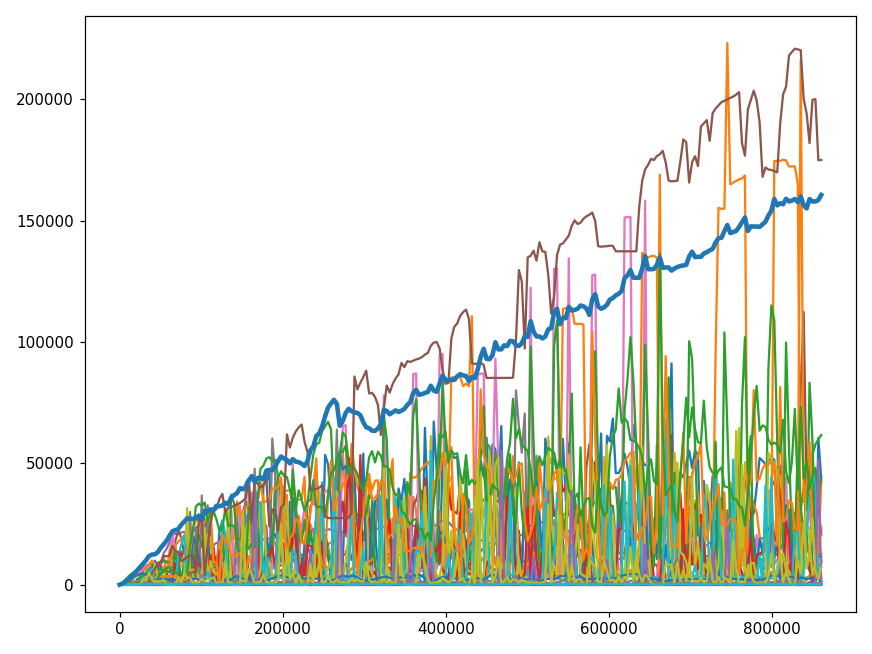

In [357]:
fig_2, ax_2 = plt.subplots(figsize=(8,6))

for i in range(n_clusters):
    cluster_i = np.array(node_names[2])[clustering.labels_==i]
    dqual_std_i = results.node['quality'][cluster_i].dropna().std(axis=1)
    
    ax_2.plot(dqual_std_i, label=str(i))
    
dqual_std_ges = results.node['quality'].dropna().std(axis=1)
ax_2.plot(dqual_std_ges, linewidth=3)

fig_2.tight_layout()  

Export Cluster label

In [363]:
cluster_labels.to_json('./Surrogate_Model/cluster_labels.json')